In [1]:
import sys
sys.path.append('..')
from data_utils import *

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

import matplotlib.pyplot as plt

In [2]:
# Loading in data
load_wfs = np.load('10k_flashes.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

# Splitting data
val_ratio = 0.1
test_ratio = 0.05
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
    """
    waveforms, arrival_times = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)
    waveforms = waveforms.unsqueeze(1)  # adding channel dimension

    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    return waveforms, arrival_times
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

torch.Size([25, 1, 16000])


Text(0.5, 1.0, 'Batch of 25 1D Waveforms')

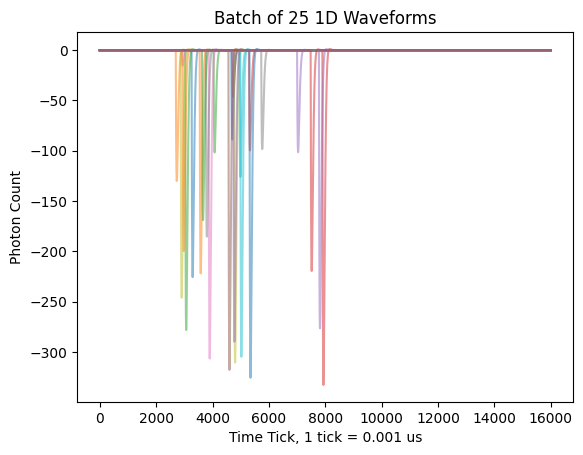

In [3]:
# Inspecting data
waveforms, arrival_times = next(iter(train_loader))
print(waveforms.shape)
ticks = np.arange(waveforms[0].shape[1])

for wf in waveforms:
    plt.plot(ticks, wf.squeeze(0), alpha=0.5)
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("Photon Count")
plt.title(f"Batch of {len(waveforms)} 1D Waveforms")

In [4]:
# Doing the training yuhh
from model import *
from utils import *
import torch.optim as optim
import wandb

epochs = 7
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="supervised flash ids",
    name="single-flashes-run1",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = UNet1D()
model.to(device)
wandb.watch(model, log="all", log_freq=100)

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) # trying out learning rate decay

# def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
results = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, logger)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carsmith (carsmith-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


                                                            
Validation Epoch 5: 100%|██████████| 40/40 [00:01<00:00, 38.36it/s]
                                                                   

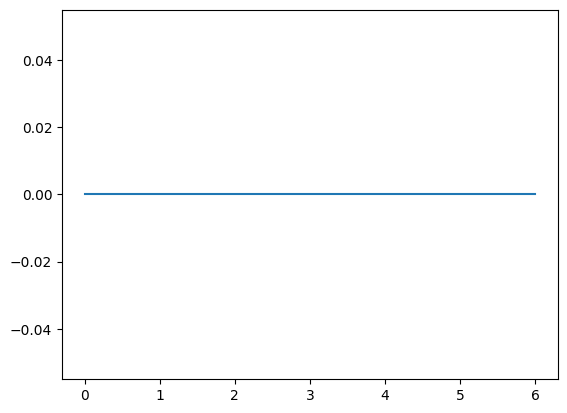

In [5]:
ticks = np.arange(epochs)
plt.plot(ticks, results['train_loss'])